In [1]:
import math
import copy
from task import Task
from caseLoader import CaseLoader
from taskType import TaskType
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# global variable :D
rand = random.Random()

def get_ready(task_set, cycle, ready_list):
    for task in task_set:
        if cycle % task.period == 0:
            new_job = copy.deepcopy(task)
            new_job.deadline = new_job.deadline + cycle
            new_job.release_time = cycle
            ready_list.append(new_job)
    
    # sort on deadline
    # https://www.geeksforgeeks.org/sorting-objects-of-user-defined-class-in-python/
    ready_list = sorted(ready_list, key=lambda t: t.deadline) 
    
    return ready_list
        

# ts is set of TT tasks
def edf(ts):
    #print("in edf: ", ts[-1].name, ts[-1].duration, ts[-1].period, ts[-1].deadline)
    periods = [t.period for t in ts]
    T = math.lcm(*periods) # least common multiple of TT task periods. 2000 mt = 
    #print(T)
    s = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    for t in range(0, T):
        for task in ready_list:
            if task.duration > 0 and task.deadline <= t:
                #print(t)
                #for task in ready_list:
                #    print("name: ", task.name, " duration: ", task.duration, " deadline: ", task.deadline, " period: ", task.period, " release: ", task.release_time)
                return s, -1
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name]:
                    wcrts[task.name] = response_time
                
                ready_list.remove(task)
                
        # release taks at time t
        ready_list = get_ready(ts, t, ready_list)

        if ready_list == []:
            s.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            s.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    #print("in EDF wcrts is: ", wcrts)
    
    return s, wcrts

In [3]:
def unpack(task):
    return (task.priority, task.duration, task.period, task.deadline)

#Schedulability of ET tasks under a given polling task
def calculate_schedulabiltiy(ps, task_periods):
    Tp = ps.period
    Dp = ps.deadline
    Cp = ps.duration
    result_dict = {}
    
    #compute delta and alpha accordingly to [2]
    Delta = Tp + Dp - 2*Cp
    alpha = Cp/Tp
    
    #hyperperiod is lcm of all task periods in T_ET (all values must be from the chosen subset of ET tasks from the .csv)
    periods = [t.period for t in task_periods]
    #for task in task_periods:
    #    (pi, Ci, Ti, Di) = unpack(task)
    #    periods.append(Ti)

    
    hyperperiod = math.lcm(*periods)
    #print("hyperperiod ets is ", hyperperiod)

    for task_period in task_periods:
        (pi, Ci, Ti, Di) = unpack(task_period)
        t = 0
        #initialize the response time of ti (task period) to a value exceeding the deadline
        response_time = Di + 1

        #remember we are dealing with constrained deadline tasks for the AdvPoll, hence, in the worst case arrival pattern, the intersection must lie within the hyperperiod if the task is schedulable

        while t <= hyperperiod:
            #the supply at time t ([1])
            supply = alpha*(t-Delta)

            #compute the maximum demand at time t according to Eq. 2
            demand = 0
            for tj in task_periods:
                (pj, Cj, Tj, Dj) = unpack(tj)

                if pj >= pi:
                    demand  = demand + math.ceil(t/Tj)*Cj
            
            #According to lemma 1 of [1], we are searching for the earliest time, when the supply exceeds the demand
            if supply >= demand:
                response_time = t
                result_dict[task_period.name]  = (True, response_time, task_period.deadline) # if actually greater than deadline, set to false later
                break
            
            t = t + 1
        
        if response_time > Di:
            result_dict[task_period.name] = (False, response_time, task_period.deadline)
            
        
    return result_dict # contains wcrt and bool indicating schedulability for each et



def cost_f(task_set):
    
    polling_servers = [ps for ps in task_set if ps.et_subset != None]
    
    l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
    ps = polling_servers[0]
    # https://www.geeksforgeeks.org/reduce-in-python/
    # create list of bools by applying schedulability check for ets, fold into single bool using and.
    
    wcrts_et = 0
    is_schedulable = True
    for entry in l:
        wcrts_et += (sum([(entry[key][1] / entry[key][2]) if entry[key][0] else 1 for key in entry]) / len(entry))
        is_schedulable = is_schedulable and reduce((lambda a, b : a and b), [entry[key][0] for key in entry])
        
    wcrts_et *= 1/len(l) 
    #print("is schedulable: ", is_schedulable)
        
    #print("in cost1: ", len(task_set), "dur: ", ps.duration, "per: ", ps.period, "dead: ", ps.deadline)

    s, wcrts = edf(task_set)
    #for i,ps in enumerate(task_set):
    #    if ps.et_subset != None:
    #        print("in cost2 i is:", i, " ", len(task_set), "dur: ", ps.duration, "per: ", ps.period, "dead: ", ps.deadline)
    
    if wcrts == -1:
        return s, 2, False
    
    #print("IN COST not -1")
    sum_wcrts_tt = sum([wcrts[task.name] / task.deadline for task in task_set])
    #sum_wcrts_tt = sum([wcrts[key][0] / wcrts[key][1]  for key in wcrts])
    #print("in cost: ", sum_wcrts_tt)
    
    #return s, sum_wcrts_tt
    
    #alternative 0 <= sum <= 1
    sum_wcrts_tt = sum_wcrts_tt / len(task_set)
    sum_wcrts = (sum_wcrts_tt + wcrts_et)
    
    assert 0 <= sum_wcrts and sum_wcrts <= 2
    
    return s, sum_wcrts, is_schedulable

In [4]:
"""
Determine: You will have to design and implement an optimization algorithm that
determines an optimized solution which consists of the following: (i) The number of polling
servers, which then become extra TT tasks. (ii) For each polling server (task), the period,
budget, and deadline, as well as (iii) which sub-sets of ET tasks are handled within the
respective polling servers. Moreover, the TT tasks also need to be schedulable, i.e., given the
found polling tasks (and their parameters), it shall be possible to find (iv) a TT schedule
such that also the TT tasks are schedulable

"""

NUM_PS = 0
BUDGET = 1
PERIOD = 2
DEADLINE = 3
SUBSET = 4

# get a subset of pses from victim and delete these from victim
# -1 to not steal all, max (1, otherthing) to not get rand(1, -x)
def get_subset(s, victim_ps):
    num_et_tasks = rand.randint(1, max(1, len(victim_ps.et_subset) - 1)) 
    new_ps_et_subset = []
        
    for task in victim_ps.et_subset[0:num_et_tasks]:
        new_ps_et_subset.append(task)
        victim_ps.et_subset.remove(task)
        
    return new_ps_et_subset
    
# take polling servers as arg, 
def neighborhood(polling_servers):
    # select randomly a ps then randomly choose to change:
        # num_ps, period, budget, deadline or subset of et_tasks
        # et_tasks will have to take some from another/give 
        # do not worry whether newly generated solution is feasible 
        # return new solution 
    
    # num_ps, period, budget, deadline, subset
    
    # select parameter to change. skip adding/removing ps for now
    parameter = rand.randint(1, 3)
    
    # sel
    victim_ps = polling_servers[rand.randint(0,len(polling_servers)) % len(polling_servers)] # victim to change etc.
    
    # increase or decrease chosen parameter
    sign = 1 if rand.randint(0,1) == 0 else -1
    
    # only adds a polling server. add functionality to remove one and move et subset to other ps
    if parameter == NUM_PS:
        new_ps_et_subset = get_subset(polling_servers, victim_ps)
        new_ps = Task("tTT" + str(rand.randint(0,5000)), 1000, 1000, TaskType.TIME, 7, 1000, new_ps_et_subset)
        
        return polling_servers + [new_ps]
    
    elif parameter == BUDGET:
        victim_ps.duration = max(5, victim_ps.duration + sign * 10)
        
    elif parameter == PERIOD:
        victim_ps.period = max(5, victim_ps.period + sign * 100)
        victim_ps.period = max(victim_ps.period, victim_ps.deadline) # do not accept period < deadline for now 

    elif parameter == DEADLINE:
        victim_ps.deadline = max(5, victim_ps.deadline + sign * 100)
        victim_ps.deadline = min(victim_ps.period, victim_ps.deadline) # do not accept period < deadline for now 

    elif parameter == SUBSET:
        if len(polling_servers) == 1: # if no one to steal from 
            return polling_servers 
        other_ps_victim = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]

        while other_ps_victim == victim_ps:
            other_ps_victim = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]
            
        new_ps_et_subset = get_subset(polling_servers, other_ps_victim)
        
        victim_ps.et_subset += new_ps_et_subset
        
    return polling_servers # should be copy no?

In [5]:

rand = random.Random()

# decays as delta increases or temperature decresases 
def p(delta, t):
    return np.exp( -delta / t )

# simulated annealing 
def sa(s0, t, a, stopcriterion_sec, neighborhood_f = None, cost_f=None, log_costs = False):
    # used to determine if stop criterion is reached
    sec0 = int(time.time())
    
    # get tt and et tasks
    tt = [t for t in s0 if t.type == TaskType.TIME and t.et_subset == None]
    et = [t for t in s0 if t.type == TaskType.EVENT]
    polling_servers = [t for t in s0 if t.et_subset != None]
    
    # current and best solution
    current_solution = tt + polling_servers
    
    # schedule has 1 entry pr. cycle. current_cost is some number. is_schedulable boolean true if schedulable, 
    # sometimes we accept infeasible solution bc. they may lead to good solutions. 
    schedule, current_cost, is_schedulable = cost_f(current_solution)
    best_solution = copy.deepcopy(current_solution)
    best_cost = current_cost
    best_ps_config = polling_servers
    
    # logging 
    print("cost 0: ", current_cost)
    
    # for logging purposes
    n_solutions = 0
    cost_log = []
    
    # does not matter if < or <= if 0 then new solution will be selected no matter what     
    while int(time.time()) - sec0 < stopcriterion_sec:
        # obtain ps configuration from neighborhood. create temporary solution
        tmp_ps = neighborhood_f(copy.deepcopy(polling_servers)) # feel like we should call with a copy?
        tmp_solution = tt + tmp_ps
        
        # compute schedule, cost and is_schedulable
        tmp_schedule, tmp_cost, is_schedulable = cost_f(tmp_solution)
        
        # compute delta
        delta = tmp_cost - current_cost
        
        # logging
        n_solutions = n_solutions + 1
        
        # logging
        if delta > 0:
            print("tmp_cost: ", tmp_cost, "delta: ", delta, " t: ", t, " p(delta, t): ", p(delta, t))
        
        # accept randomly drawn solution from current neighborhood if better or with some probability
        if delta <= 0 or p(delta, t) > rand.uniform(0.0, 1.0):
            #print("yo")
            polling_servers = copy.deepcopy(tmp_ps) # all these copies...
            current_solution = tmp_solution # update current solution, current set of polling servers, costs & schedule
            current_cost = tmp_cost
            tmp_cost = tmp_schedule[:]
                         
            if log_costs: # logging
                cost_log.append(current_cost)
            
            # keep track of the best solution. save all the things.. only accept schedulable configs. 
            if current_cost < best_cost and is_schedulable:
                best_solution = current_solution
                best_schedule = schedule[:]
                best_cost = current_cost
                best_ps_config = copy.deepcopy(polling_servers)
                print("Updated best solution")
                
        # update temperature 
        t = t * a
        
    return (schedule, best_cost, cost_log, best_ps_config) if log_costs else (schedule, best_cost, best_ps,config) 
    

In [6]:
loader = CaseLoader()
all_tasks = loader.load_test_case("inf_30_30", 0)
tt_tasks = [t for t in all_tasks if t.type == TaskType.TIME]
et_tasks = [t for t in all_tasks if t.type == TaskType.EVENT]


Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [7]:
polling_servers_0 = [Task("tTTps00",500, 1000, TaskType.TIME, 7, 1000, et_tasks)]
#polling_servers_0 = [Task("tTTps00", rand.randint(1, 10000), rand.randint(1, 10000), TaskType.TIME, 7, rand.randint(1, 10000), et_tasks)]
#tt_tasks = tt_tasks + polling_servers_0

In [8]:
#polling_servers_0 = [Task("tTTps00",200, 2000, TaskType.TIME, 7, 2000, et_tasks)]
task_set = tt_tasks + polling_servers_0
print("name: ", tt_tasks[-1].name, " duration: ", tt_tasks[-1].duration, " deadline: ", tt_tasks[-1].deadline, " period: ", tt_tasks[-1].period, tt_tasks[-1].release_time)

name:  tTT29  duration:  4  deadline:  4000  period:  4000 0


In [9]:
schedule, cost_best, cost_log, best_ps_config = sa(task_set, 2, .99, 600, neighborhood_f = neighborhood, cost_f=cost_f, log_costs=True)

cost 0:  1.2548755780558365
tmp_cost:  1.299733801271831 delta:  0.04485822321599442  t:  2  p(delta, t):  0.977820550863058
tmp_cost:  1.2548755780558365 delta:  0.006484093124323076  t:  1.92119202  p(delta, t):  0.99663065256825
tmp_cost:  1.25710858540456 delta:  0.03614889585991388  t:  1.8829602988019998  p(delta, t):  0.9809851996307475
tmp_cost:  1.2643623752195217 delta:  0.007253789814961609  t:  1.8641306958139798  p(delta, t):  0.9961163157811072
tmp_cost:  1.299657253711029 delta:  0.03641771306421493  t:  1.8270344949672814  p(delta, t):  0.9802646522403055
tmp_cost:  1.4040778792168722 delta:  0.10615035864183087  t:  1.7906765085174325  p(delta, t):  0.9424433454570313
tmp_cost:  2 delta:  0.5959221207831278  t:  1.7727697434322582  p(delta, t):  0.714513674784931
tmp_cost:  1.263239540646814 delta:  0.0029535039677346386  t:  1.7201167092825767  p(delta, t):  0.9982844363032408
tmp_cost:  1.265215301799154 delta:  0.0019757611523401053  t:  1.7029155421897508  p(delta,

tmp_cost:  1.3229784946236558 delta:  0.0005099620493358437  t:  0.3147065642155793  p(delta, t):  0.998380875552765
tmp_cost:  1.3137311827956988 delta:  0.01155913978494616  t:  0.3053594645518124  p(delta, t):  0.9628533098090651
tmp_cost:  1.3183413978494625 delta:  0.004610215053763689  t:  0.30230586990629427  p(delta, t):  0.9848655277563848
tmp_cost:  1.3224179316888045 delta:  0.004598355471220561  t:  0.296289983095159  p(delta, t):  0.9846000307804387
tmp_cost:  1.3229516129032257 delta:  0.0005336812144212111  t:  0.2933270832642074  p(delta, t):  0.9981822475741322
tmp_cost:  1.317819576217584 delta:  0.0004638414505586663  t:  0.2817688258085354  p(delta, t):  0.9983551768865895
tmp_cost:  1.301208781362007 delta:  0.0004055838521033195  t:  0.2679593497159235  p(delta, t):  0.9984875427521348
tmp_cost:  1.3127679211469534 delta:  0.011559139784946382  t:  0.26527975621876426  p(delta, t):  0.9573622852515434
tmp_cost:  1.304473259762309 delta:  0.0008092812676852024  t: 

tmp_cost:  1.2866358840063445 delta:  0.009363171316226104  t:  0.0794195572240135  p(delta, t):  0.8887893413088668
tmp_cost:  1.3195699791282456 delta:  0.03293409512190104  t:  0.07862536165177336  p(delta, t):  0.6577872771457555
tmp_cost:  1.3550934147264586 delta:  0.03552343559821303  t:  0.07783910803525562  p(delta, t):  0.6335793541844811
tmp_cost:  1.4048706966254483 delta:  0.0853007174972027  t:  0.07629010978535403  p(delta, t):  0.3268971200615983
tmp_cost:  1.4048706966254483 delta:  0.030231723564988933  t:  0.07477193660062548  p(delta, t):  0.6674310970445044
tmp_cost:  1.4444976913764083 delta:  0.03962699475095999  t:  0.07402421723461922  p(delta, t):  0.5854791315197739
tmp_cost:  1.4769274008517292 delta:  0.03242970947532098  t:  0.07328397506227302  p(delta, t):  0.6424147488942843
tmp_cost:  1.645356085582232 delta:  0.2412782063653598  t:  0.07182562395853379  p(delta, t):  0.03476229823423334
tmp_cost:  1.2675184684386793 delta:  0.007232431759599978  t:  0

tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.020449313461192043  p(delta, t):  0.7294018153873817
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.02004237212331432  p(delta, t):  0.6739385192613767
tmp_cost:  1.12875771614117 delta:  0.05297469582912617  t:  0.019841948402081176  p(delta, t):  0.0692637662598083
tmp_cost:  1.12875771614117 delta:  0.05297469582912617  t:  0.019643528918060364  p(delta, t):  0.06742082202294321
tmp_cost:  1.1257971356894674 delta:  0.05303229951576216  t:  0.01925262269259096  p(delta, t):  0.06363769089855162
tmp_cost:  1.1257971356894674 delta:  0.05303229951576216  t:  0.018680800545998313  p(delta, t):  0.058491926961151935
tmp_cost:  1.0757830203120438 delta:  0.003018184138338542  t:  0.01849399254053833  p(delta, t):  0.8494229151098852
tmp_cost:  1.1257971356894674 delta:  0.05303229951576216  t:  0.018309052615132947  p(delta, t):  0.05521575086062134
tmp_cost:  1.1257971356894674 delta:  0.05303229951576216

tmp_cost:  2 delta:  0.932126028221163  t:  0.006246427370758286  p(delta, t):  1.5566968424844955e-65
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.006183963097050703  p(delta, t):  0.3522529690211305
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.005940290277014148  p(delta, t):  1.6238990945604622e-05
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.005880887374244006  p(delta, t):  1.4527164292646202e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.005706219138341585  p(delta, t):  0.3227868268699142
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.005592665377488587  p(delta, t):  8.182017229472534e-06
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.005536738723713701  p(delta, t):  0.2396760650833961
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.0054265576231117985  p(delta, t):  5.7166588038193235e-06
tmp_cost:  1.0757830203120438 delta:  0.007909048533206

tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.0022408951858531117  p(delta, t):  2.0131774668699686e-13
tmp_cost:  2 delta:  0.932126028221163  t:  0.0022184862339945806  p(delta, t):  3.353428849601343e-183
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.002196301371654635  p(delta, t):  0.027294333273685585
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0021743383579380885  p(delta, t):  0.05143094224905816
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0021525949743587077  p(delta, t):  0.049912180871802526
tmp_cost:  2 delta:  0.932126028221163  t:  0.0021310690246151205  p(delta, t):  1.0972857911036469e-190
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.0021097583343689694  p(delta, t):  3.2713411084023757e-14
tmp_cost:  2 delta:  0.932126028221163  t:  0.0020886607510252797  p(delta, t):  1.5253474997073815e-194
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.00206777414351

tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.0006708800776306236  p(delta, t):  7.587074068253421e-06
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006641712768543173  p(delta, t):  6.037488534660631e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006509542684449165  p(delta, t):  4.956676920306242e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006444447257604673  p(delta, t):  4.484434541718006e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006380002785028627  p(delta, t):  4.05308343979812e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006253040729606557  p(delta, t):  3.30069807551139e-05
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0006190510322310491  p(delta, t):  2.9739878634849018e-05
tmp_cost:  2 delta:  0.932126028221163  t:  0.0006128605219087387  p(delta, t):  0.0
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t: 

tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.00022659269869514023  p(delta, t):  4.297017073112708e-13
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  0.0002243267717081888  p(delta, t):  3.222920367341157e-13
tmp_cost:  2 delta:  0.932126028221163  t:  0.0002220835039911069  p(delta, t):  0.0
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.00021986266895119585  p(delta, t):  2.383775524434507e-16
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.00021766404226168388  p(delta, t):  1.9539204539319836e-131
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.00021548740183906703  p(delta, t):  9.345725249702041e-133
tmp_cost:  1.1333840594142013 delta:  0.06551008763536426  t:  0.00021333252782067635  p(delta, t):  4.334937473386592e-134
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  0.00021119920254246958  p(delta, t):  5.4502349513577655e-17
tmp_cost:  1.0757830203120438 delta:  0.0079090485

tmp_cost:  2 delta:  0.932126028221163  t:  7.808660462793843e-05  p(delta, t):  0.0
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  7.653268119584246e-05  p(delta, t):  1.3155069854101379e-45
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  7.576735438388404e-05  p(delta, t):  4.631809244659501e-46
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  7.500968084004519e-05  p(delta, t):  1.6137228729766731e-46
tmp_cost:  1.074326354119835 delta:  0.006452382340997875  t:  7.425958403164474e-05  p(delta, t):  1.8379977193777946e-38
tmp_cost:  2 delta:  0.932126028221163  t:  7.351698819132829e-05  p(delta, t):  0.0
tmp_cost:  2 delta:  0.932126028221163  t:  7.205400012632087e-05  p(delta, t):  0.0
tmp_cost:  1.0757830203120438 delta:  0.00790904853320673  t:  7.133346012505766e-05  p(delta, t):  7.045256003066532e-49


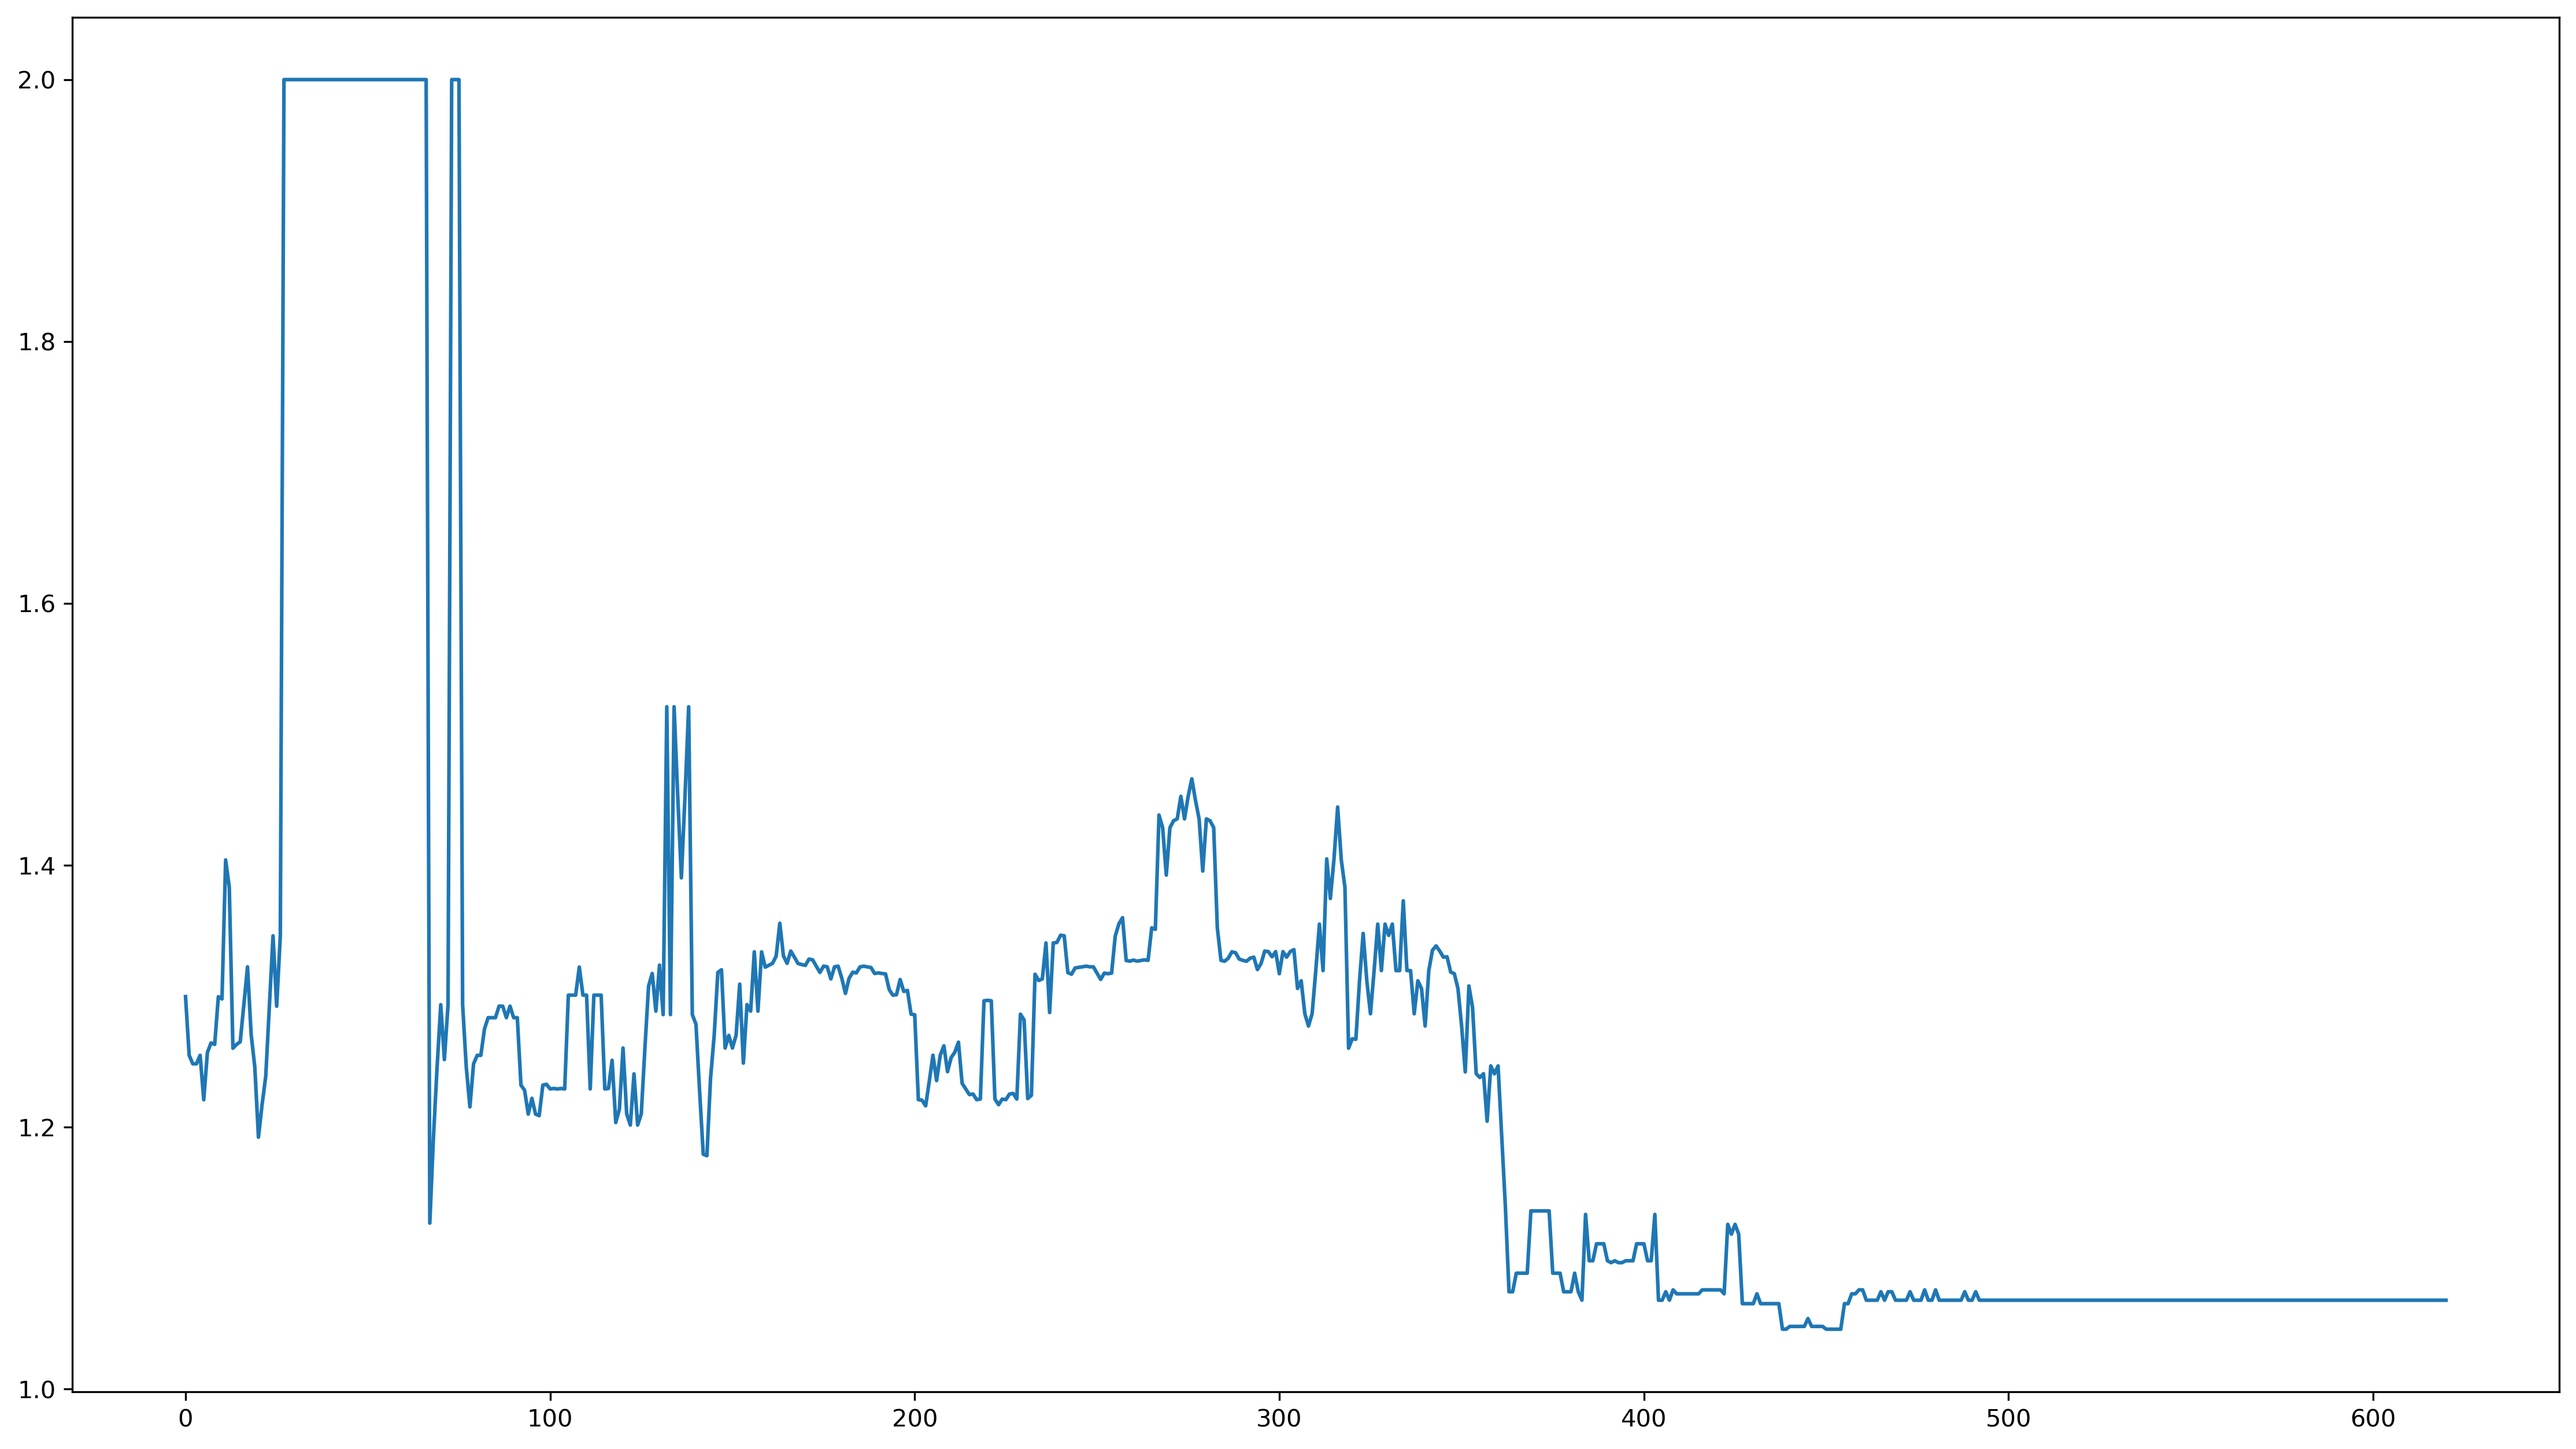

In [10]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)


In [17]:
#print(calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset))
print(best_ps_config[0].duration, best_ps_config[0].period, best_ps_config[0].deadline)
schedule, cost, is_schedulable = cost_f(tt_tasks + best_ps_config)
print(cost, is_schedulable)
calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)



400 700 700
1.0457372415174782 True


{'tET8': (True, 2714, 3847),
 'tET13': (True, 2714, 3824),
 'tET0': (True, 1783, 3655),
 'tET19': (True, 1783, 3224),
 'tET5': (True, 1453, 2819),
 'tET4': (True, 1323, 2394),
 'tET16': (True, 1323, 2266),
 'tET1': (True, 1323, 2106),
 'tET2': (True, 1157, 2073),
 'tET18': (True, 1157, 1864),
 'tET14': (True, 1157, 1813),
 'tET15': (True, 1157, 1793),
 'tET6': (True, 1157, 1773),
 'tET11': (True, 908, 1581),
 'tET12': (True, 908, 1509),
 'tET7': (True, 908, 1348),
 'tET3': (True, 908, 1145),
 'tET17': (True, 908, 1121),
 'tET9': (True, 908, 1117),
 'tET10': (True, 908, 1103)}